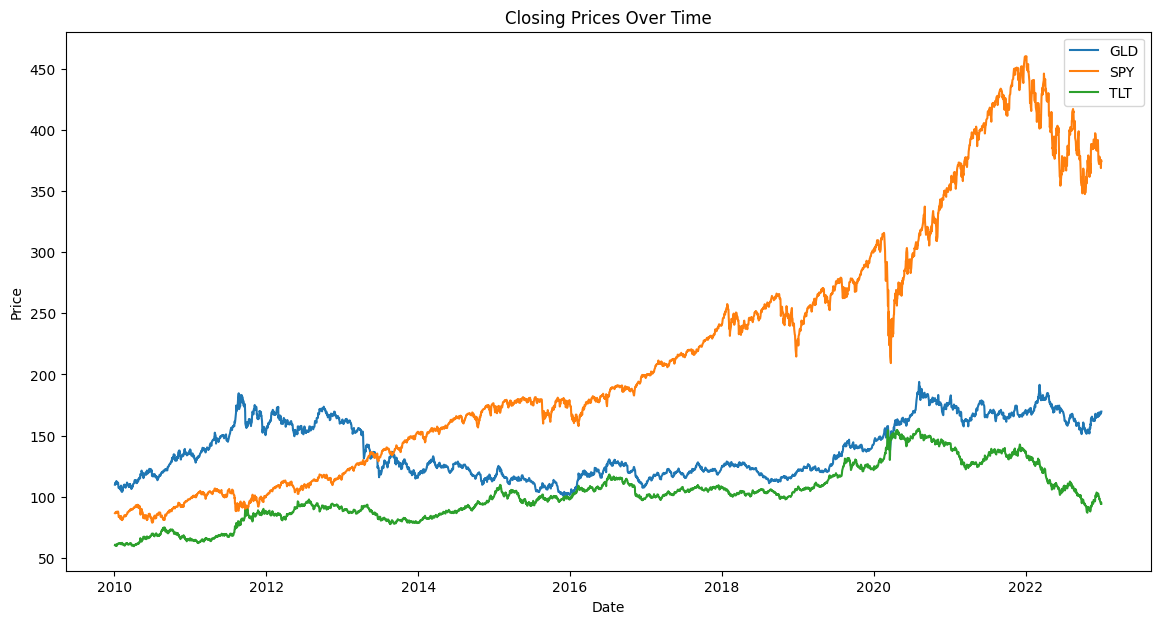

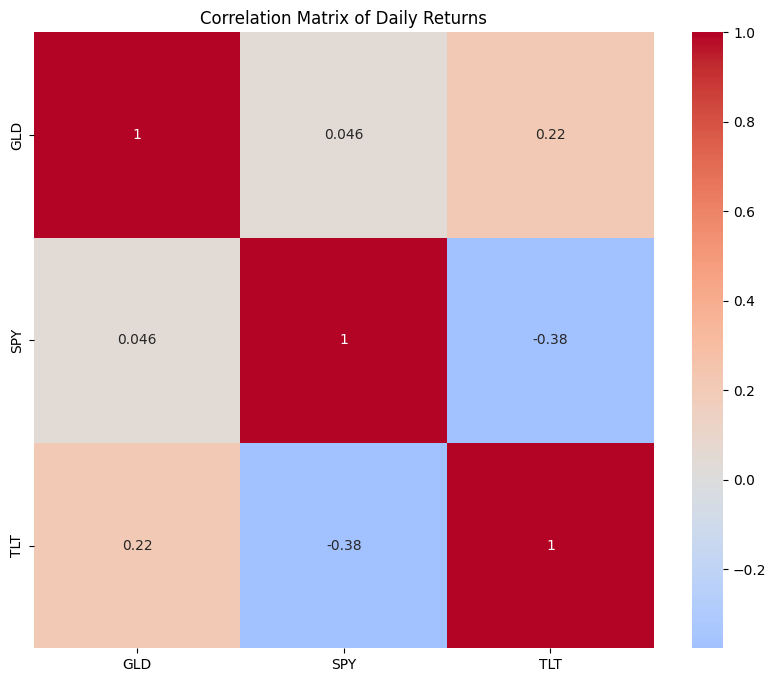

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data = pd.read_csv("tail_risk_hedging_data.csv", index_col='Date', parse_dates=True)

# Plot the closing prices
plt.figure(figsize=(14, 7))
plt.plot(data)
plt.title('Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(data.columns)
plt.show()

# Calculate daily returns
returns = data.pct_change().dropna()



# Calculate and plot the correlation matrix
correlation_matrix = returns.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Daily Returns')
plt.show()


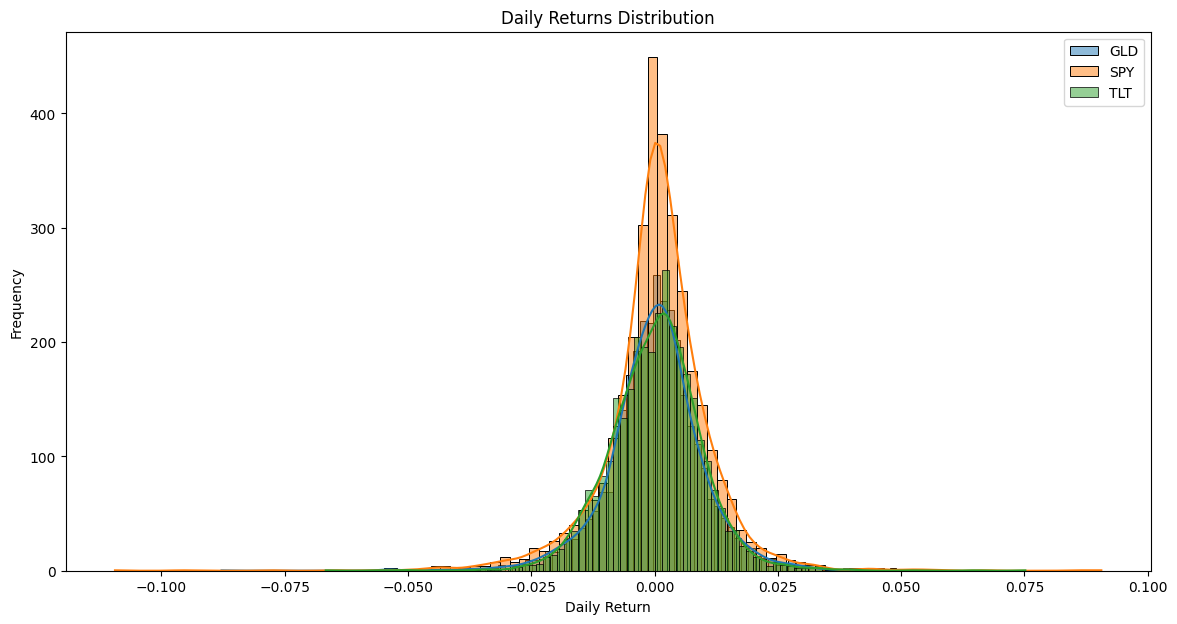

In [14]:
# Plot the distribution of daily returns
plt.figure(figsize=(14, 7))
for column in returns.columns:
    sns.histplot(returns[column], bins=100, kde=True, label=column)
plt.title('Daily Returns Distribution')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.legend()
plt.show()

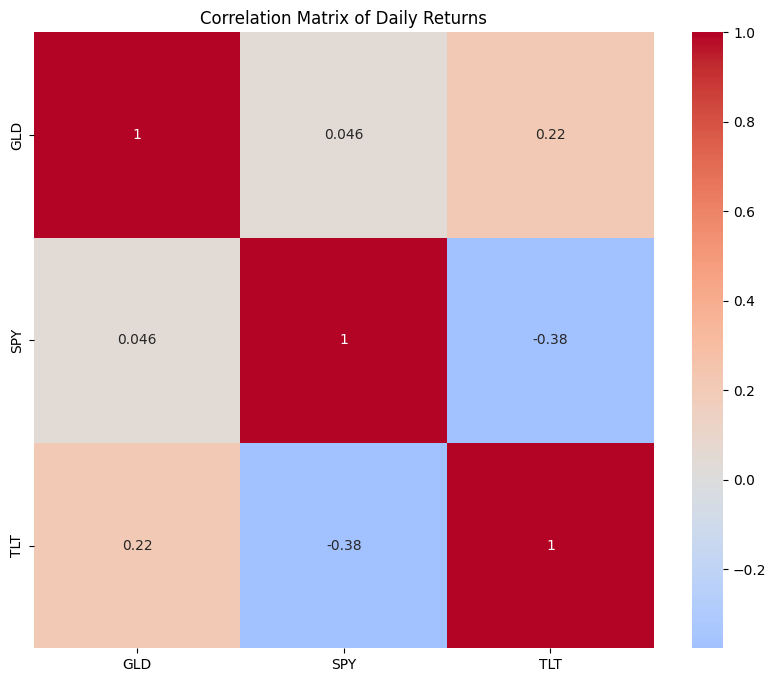

In [15]:
# Calculate and plot the correlation matrix
correlation_matrix = returns.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Daily Returns')
plt.show()


In [16]:
import numpy as np

# Define the population size and number of genes (parameters to optimize)
population_size = 10
num_genes = 3  # hedge ratios for SPY, TLT, GLD

# Define the gene space (range of values for each gene)
gene_space = [(0.01, 0.3), (0.01, 0.3), (0.01, 0.3)]

# Initialize the population with random values within the gene space
population = np.random.uniform(low=[gene[0] for gene in gene_space],
                               high=[gene[1] for gene in gene_space],
                               size=(population_size, num_genes))

print("Initial Population:")
print(population)


Initial Population:
[[0.27892326 0.17920955 0.01119735]
 [0.16249112 0.21622662 0.17922045]
 [0.08367759 0.25916185 0.22983762]
 [0.0486235  0.2143557  0.24655739]
 [0.27573375 0.11283213 0.20425955]
 [0.23838745 0.23118816 0.22205805]
 [0.09181859 0.17061152 0.13644107]
 [0.11398189 0.10608462 0.18523814]
 [0.0670794  0.0315934  0.19026653]
 [0.01337394 0.17790258 0.17118829]]


In [17]:
import pandas as pd

# Load the dataset
data = pd.read_csv("tail_risk_hedging_data.csv", index_col='Date', parse_dates=True)

def fitness_func(solution):
    hedge_ratio_spy, hedge_ratio_tlt, hedge_ratio_gld = solution
    capital = 10000  # Starting capital
    position_spy = 0
    position_tlt = 0
    position_gld = 0
    buy_price_spy = 0
    buy_price_tlt = 0
    buy_price_gld = 0

    for index, row in data.iterrows():
        if position_spy == 0 and position_tlt == 0 and position_gld == 0:
            buy_price_spy = row['SPY']
            buy_price_tlt = row['TLT']
            buy_price_gld = row['GLD']
            position_spy = 1
            position_tlt = 1
            position_gld = 1

        elif position_spy == 1 and position_tlt == 1 and position_gld == 1:
            capital += (row['SPY'] - buy_price_spy) * (capital / buy_price_spy) * hedge_ratio_spy
            capital += (row['TLT'] - buy_price_tlt) * (capital / buy_price_tlt) * hedge_ratio_tlt
            capital += (row['GLD'] - buy_price_gld) * (capital / buy_price_gld) * hedge_ratio_gld
            position_spy = 0
            position_tlt = 0
            position_gld = 0

    return capital

# Evaluate the initial population
fitness_values = np.array([fitness_func(individual) for individual in population])
print("Initial Fitness Values:")
print(fitness_values)


Initial Fitness Values:
[12954.31836968 11639.60595979 10657.05645622 10394.49526845
 13467.26602546 12629.17348586 10850.54280681 11347.78312772
 10974.43228855  9998.19449977]


In [18]:
def roulette_wheel_selection(population, fitness_values, num_parents):
    total_fitness = np.sum(fitness_values)
    probabilities = fitness_values / total_fitness
    selected_parents_indices = np.random.choice(np.arange(len(population)), size=num_parents, p=probabilities)
    parents = population[selected_parents_indices]
    return parents

num_parents = 5
parents = roulette_wheel_selection(population, fitness_values, num_parents)
print("Selected Parents:")
print(parents)


Selected Parents:
[[0.0670794  0.0315934  0.19026653]
 [0.09181859 0.17061152 0.13644107]
 [0.01337394 0.17790258 0.17118829]
 [0.23838745 0.23118816 0.22205805]
 [0.11398189 0.10608462 0.18523814]]


In [19]:
def single_point_crossover(parents, offspring_size):
    offspring = np.empty(offspring_size)
    crossover_point = np.uint8(offspring_size[1] / 2)

    for k in range(offspring_size[0]):
        parent1_idx = k % parents.shape[0]
        parent2_idx = (k + 1) % parents.shape[0]
        offspring[k, 0:crossover_point] = parents[parent1_idx, 0:crossover_point]
        offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]

    return offspring

offspring_size = (population_size - num_parents, num_genes)
offspring_crossover = single_point_crossover(parents, offspring_size)
print("Crossover Offspring:")
print(offspring_crossover)


Crossover Offspring:
[[0.0670794  0.17061152 0.13644107]
 [0.09181859 0.17790258 0.17118829]
 [0.01337394 0.23118816 0.22205805]
 [0.23838745 0.10608462 0.18523814]
 [0.11398189 0.0315934  0.19026653]]


In [20]:
def mutation(offspring_crossover, gene_space):
    for idx in range(offspring_crossover.shape[0]):
        gene_idx = np.random.randint(0, offspring_crossover.shape[1])
        random_value = np.random.uniform(low=gene_space[gene_idx][0], high=gene_space[gene_idx][1])
        offspring_crossover[idx, gene_idx] = random_value

    return offspring_crossover

offspring_mutation = mutation(offspring_crossover, gene_space)
print("Mutated Offspring:")
print(offspring_mutation)


Mutated Offspring:
[[0.0670794  0.10634185 0.13644107]
 [0.09181859 0.17790258 0.18913747]
 [0.04964775 0.23118816 0.22205805]
 [0.23838745 0.28488604 0.18523814]
 [0.03960808 0.0315934  0.19026653]]


In [21]:
num_generations = 50

for generation in range(num_generations):
    # Evaluate the fitness of the current population
    fitness_values = np.array([fitness_func(individual) for individual in population])

    # Select the best parents for mating
    parents = roulette_wheel_selection(population, fitness_values, num_parents)

    # Generate offspring through crossover
    offspring_crossover = single_point_crossover(parents, offspring_size)

    # Apply mutation to the offspring
    offspring_mutation = mutation(offspring_crossover, gene_space)

    # Create the new population by combining parents and offspring
    population[0:parents.shape[0], :] = parents
    population[parents.shape[0]:, :] = offspring_mutation

    # Evaluate the new population's fitness
    fitness_values = np.array([fitness_func(individual) for individual in population])
    print(f"Generation {generation + 1}: Best Fitness = {np.max(fitness_values)}")

# Output the best solution
best_solution_idx = np.argmax(fitness_values)
best_solution = population[best_solution_idx]
print(f"Best solution: Hedge Ratios = {best_solution}")
print(f"Fitness (Ending Capital): {fitness_values[best_solution_idx]}")


Generation 1: Best Fitness = 13113.684198296893
Generation 2: Best Fitness = 13320.005359195937
Generation 3: Best Fitness = 13379.513054101793
Generation 4: Best Fitness = 13379.513054101793
Generation 5: Best Fitness = 13478.885606079546
Generation 6: Best Fitness = 13067.026585133059
Generation 7: Best Fitness = 13049.549040661444
Generation 8: Best Fitness = 13049.549040661444
Generation 9: Best Fitness = 13049.549040661444
Generation 10: Best Fitness = 12972.944412700173
Generation 11: Best Fitness = 13289.037030663994
Generation 12: Best Fitness = 13289.037030663994
Generation 13: Best Fitness = 13289.037030663994
Generation 14: Best Fitness = 13289.037030663994
Generation 15: Best Fitness = 13289.037030663994
Generation 16: Best Fitness = 13758.16365156258
Generation 17: Best Fitness = 13399.842355449313
Generation 18: Best Fitness = 13289.037030663994
Generation 19: Best Fitness = 13255.78653452786
Generation 20: Best Fitness = 13452.447580570533
Generation 21: Best Fitness = 1